<img src="assets/image.png" width="600" />

# Описание системы

Система - груз, привязанный к пружине. На груз также действует некоторая внешняя сила f. Считаем силу трения равной нулю.

# Задача

Необходимо для начала дискретизировать уравнение движения системы, добавить в неё шума, а затем оценить её с использованием фильтра Калмана.

---

# Создание "исходных данных"

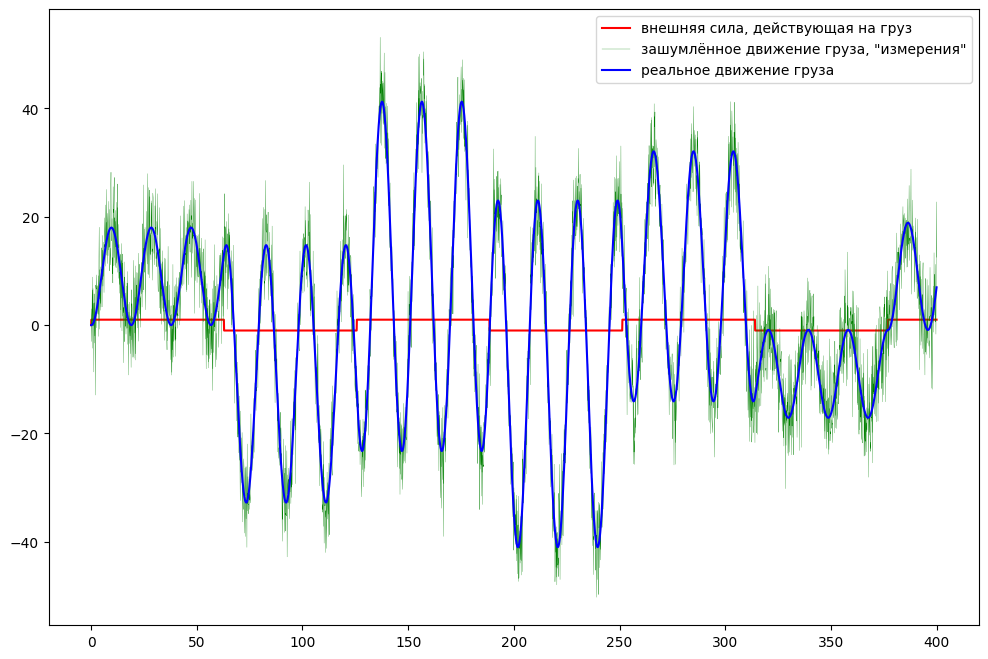

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Initial parameters
h = 0.1
w = 1 / 3
size = 400
N = int(size / h)
f = lambda x: np.sign(np.sin(0.05 * x))
y_0 = np.array([[0], [0]])
noize_variance = 5

abscissa = np.linspace(0, size, N)

# u_k calculation
u_k = np.array([f(x) for x in abscissa])

# coeff calculation
A = np.array([[0, 1], [-1, 2 - h**2 * w**2]])
B = np.array([[0], [h**2]])

# y_1 precalculation
y_1 = A @ y_0 + B * u_k[0]

# y_k declaration
y_k = np.empty((N + 1, 2, 1))
y_k[0] = y_0
y_k[1] = y_1

# x_k declaration
x_k_no_noize = np.empty(N)
x_k = np.empty(N)
CT = np.array([[1, 0]])

# noize definition
dx_k = np.random.normal(0, noize_variance, N)

# recurring calculation process
for i in range(1, N):
    y_k[i + 1] = A @ y_k[i] + B * u_k[i]
    x_k_no_noize[i] = (CT @ y_k[i]).item()
    x_k[i] = x_k_no_noize[i] + dx_k[i]

# show plot
plt.figure(figsize=(12, 8))
plt.plot(abscissa, u_k, color="red", label='внешняя сила, действующая на груз')
plt.plot(abscissa, x_k, color="green", label='зашумлённое движение груза, "измерения"', linewidth=0.2)
plt.plot(abscissa, x_k_no_noize, color="blue", label='реальное движение груза')
plt.legend()
plt.show()

---

# Фильтр Калмана

<img src="assets/image2.png" width="600" />

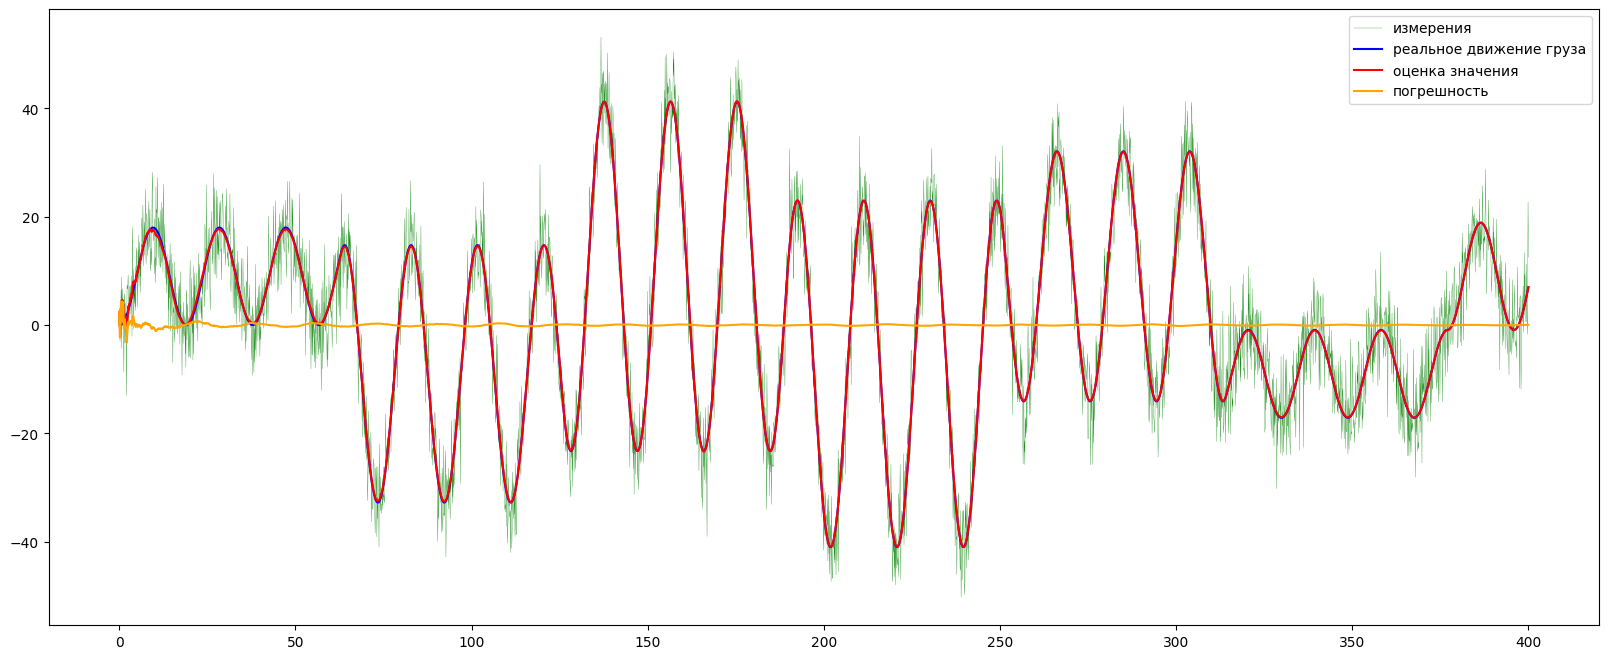

In [2]:
C = CT.transpose()

measurement_uncertainty = 5
estimate_noize_variance = 0

estimate_k = np.empty((N, 2, 1))
unsertainty_estimate_k = np.empty((N, 2, 2))

prediction_k = np.empty((N, 2, 1))
unsertainty_prediction_k = np.empty((N, 2, 2))

# Initialization
estimate_k[0] = [[0], [0]]
unsertainty_estimate_k[0] = [[30, 0], [0, 30]]

result = np.empty(N)
result[0] = (CT @ estimate_k[0])[0][0]

for i in range(1, N):
    prediction_k[i] = A @ estimate_k[i - 1] + B * u_k[i-1]
    unsertainty_prediction_k[i] = A @ unsertainty_estimate_k[i-1] @ A.transpose() + estimate_noize_variance

    kalman_gain = unsertainty_prediction_k[i] @ C / (
        CT @ unsertainty_prediction_k[i] @ C + measurement_uncertainty
    )
    estimate_k[i] = prediction_k[i] + kalman_gain * (x_k[i] - CT @ prediction_k[i])
    unsertainty_estimate_k[i] = (np.eye(2) - kalman_gain @ CT ) @ unsertainty_prediction_k[i] @ (np.eye(2) - kalman_gain @ CT).transpose() + kalman_gain * measurement_uncertainty @ kalman_gain.transpose()

    result[i] = (CT @ estimate_k[i])[0][0]

# show plot
plt.figure(figsize=(20, 8))
plt.plot(abscissa, x_k, color="green", label="измерения", linewidth=0.2)
plt.plot(abscissa, x_k_no_noize, color="blue", label="реальное движение груза")
plt.plot(abscissa, result, color="red", label="оценка значения")
plt.plot(abscissa, result - x_k_no_noize, color="orange", label="погрешность")
plt.legend()
plt.show()